In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
pd.set_option('display.max_columns',None)



from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(15,5)
%config InlineBackend.figure_format = 'png'
%matplotlib inline

Загружаем данные в датафреймы 

In [2]:
df_checks = pd.read_pickle("./df_checks.pkl")


In [3]:
df_shops = pd.read_pickle("./df_shops.pkl")
df_points = pd.read_pickle("./df_points.pkl")
df_left = pd.read_pickle("./df_left.pkl")


In [4]:

df_category = pd.read_pickle("./df_category.pkl")
df_checks_with_cat = pd.read_pickle("./df_checks_with_cat.pkl")
df_pivot_table = pd.read_pickle("./df_pivot_table.pkl")
df_week_diff = pd.read_pickle("./df_week_diff.pkl")
df_week_diff_cum = pd.read_pickle("./df_week_diff_cum.pkl")


Немного Шлифуем данные по чекам

In [5]:
df_checks_with_cat.head()

,CheckUID,id_tt_cl,id_tov_cl,Quantity,date_ch,week,BaseSum,hour,name_gr,name_gr2,good_or_bad
0,374BC969-4D99-EC11-9064-005056A7A8DF,10864,52,1.0,2022-03-01,9,119.09,13,Молочная Продукция,Сметана,-1.0
1,6A9DF7ED-7899-EC11-9064-005056A7A8DF,10864,52,1.0,2022-03-01,9,119.09,18,Молочная Продукция,Сметана,-1.0
2,6FC5327A-8499-EC11-9064-005056A7A8DF,10864,52,1.0,2022-03-01,9,119.09,20,Молочная Продукция,Сметана,-1.0
3,86F9A4A3-7199-EC11-9064-005056A7A8DF,10864,52,1.0,2022-03-01,9,119.09,18,Молочная Продукция,Сметана,-1.0
4,AC9C4F6B-5299-EC11-9064-005056A7A8DF,10864,52,1.0,2022-03-01,9,119.09,14,Молочная Продукция,Сметана,-1.0


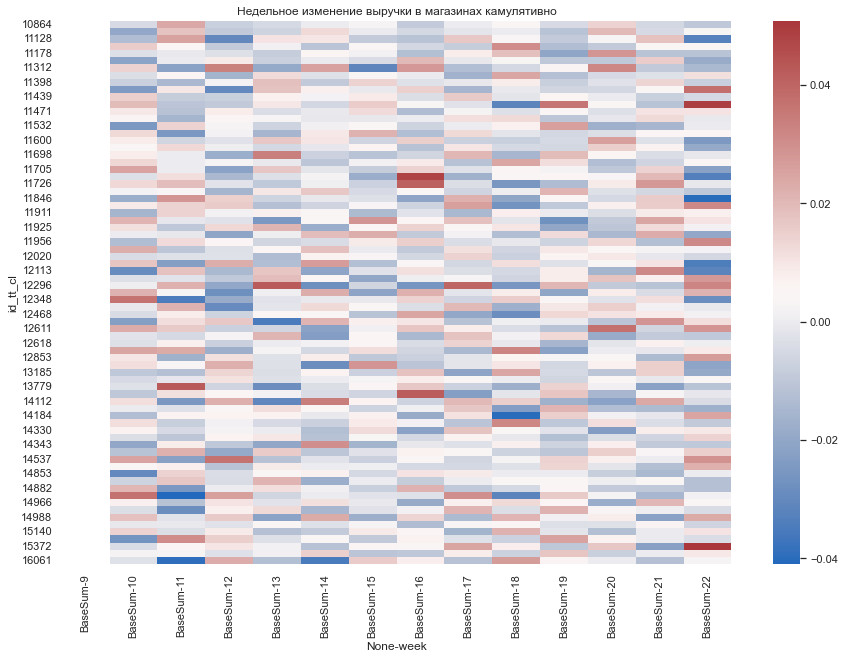

In [6]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_week_diff, cmap='vlag')
plt.title('Недельное изменение выручки в магазинах камулятивно');

In [7]:
df_category_pivot_sum = df_checks_with_cat.pivot_table(columns=['name_gr2'],index=['id_tt_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()


Исправляем кривое форматирование пивот таблицы

In [8]:

df_category_pivot_sum2 = pd.concat([df_category_pivot_sum['id_tt_cl'].to_frame(),df_category_pivot_sum.loc[:,'BaseSum']], axis=1)

Добавляем по каждому магазину суммарное количество проданных итемов -- df_category_pivot_sum2

In [9]:
df_category_pivot_sum2['overal_sum'] = df_category_pivot_sum2.drop('id_tt_cl',axis=1).sum(axis=1)

Добавляем по каждому магазину количество проданных итемов в процентах по каждой категории -- df_category_pivot_sum3

In [10]:
df_category_pivot_sum3 = df_category_pivot_sum2.copy()

In [11]:
for column in df_category_pivot_sum3.drop(['id_tt_cl','overal_sum'],axis=1):
    df_category_pivot_sum3[column] = df_category_pivot_sum3[column].div(df_category_pivot_sum3['overal_sum']/100)

In [12]:
del df_category_pivot_sum3['overal_sum']

Выбираем хорошие и плохие магазины 

In [13]:
df_average =  df_shops['id_tt'].loc[df_shops['good_or_bad'] == 0].tolist()
df_bad =  df_shops['id_tt'].loc[df_shops['good_or_bad'] == -1].tolist()
df_good = df_shops['id_tt'].loc[df_shops['good_or_bad'] == 1].tolist()

In [14]:
df_category_good = df_category_pivot_sum3.loc[df_category_pivot_sum3['id_tt_cl'].isin(df_good)]
df_category_bad = df_category_pivot_sum3.loc[df_category_pivot_sum3['id_tt_cl'].isin(df_bad)]
df_category_average = df_category_pivot_sum3.loc[df_category_pivot_sum3['id_tt_cl'].isin(df_average)]


In [15]:
df_category_good_mn = df_category_good.mean(axis=0).to_frame(name="good")
df_category_bad_mn = df_category_bad.mean(axis=0).to_frame(name="average")
df_category_average_mn = df_category_average.mean(axis=0).to_frame(name="bad")


In [16]:


df_category_diff =  pd.concat([df_category_good_mn,df_category_average_mn, df_category_bad_mn], ignore_index=False, axis=1)

In [17]:

df_category_diff = df_category_diff.drop(index='id_tt_cl')

In [18]:
df_category_diff

,good,bad,average
Авокадо,0.543638,0.588080,0.609985
Аксессуары,0.014224,0.015844,0.012457
Архив,0.000588,0.000213,0.000208
Архив Кафе,0.000116,0.018749,0.013375
"Б/а пиво, вино",0.038390,0.039522,0.033215
...,...,...,...
Экзотика,0.009677,0.019150,0.018722
Яблоки,0.933305,1.016078,1.030051
Ягоды,2.017015,2.105893,1.859633
Яйца,0.733203,0.705997,0.715488


In [24]:
df_category_diff.to_excel("subcategories_in_good_and_bad_shops_by_sum.xlsx")

In [25]:
df_category_diff.to_pickle("./subcategories_in_good_and_bad_shops_by_sum.pkl")

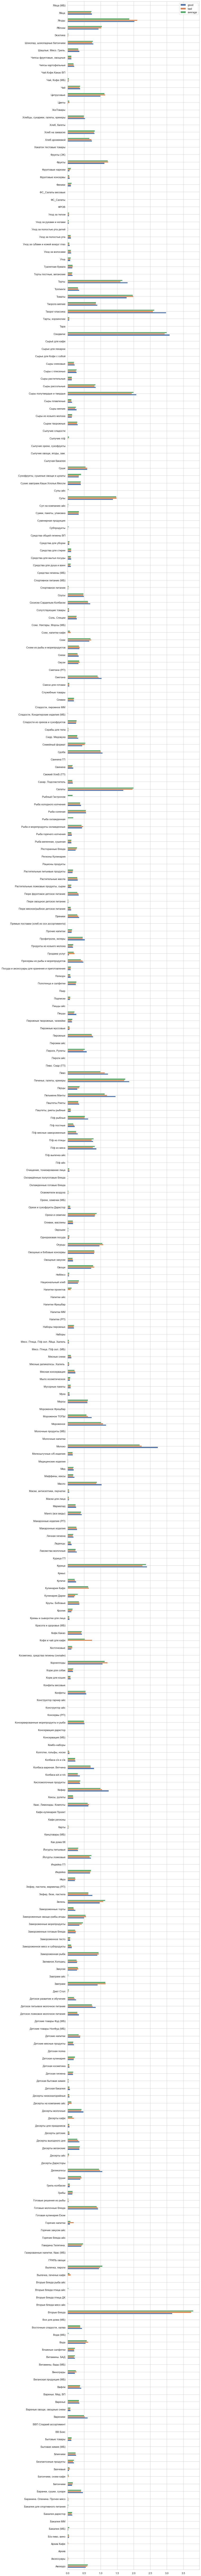

In [23]:
all_cat_perfomance = df_category_diff.plot(kind="barh",figsize=(10,200))

In [22]:
all_cat_perfomance = df_category_diff.loc[['Торты, пирожные, десерты','Сладости, кондитерские изделия','Молочная Продукция']].plot(kind="barh",figsize=(12,7))

KeyError: "None of [Index(['Торты, пирожные, десерты', 'Сладости, кондитерские изделия',\n       'Молочная Продукция'],\n      dtype='object')] are in the [index]"

NameError: name 'grap1' is not defined

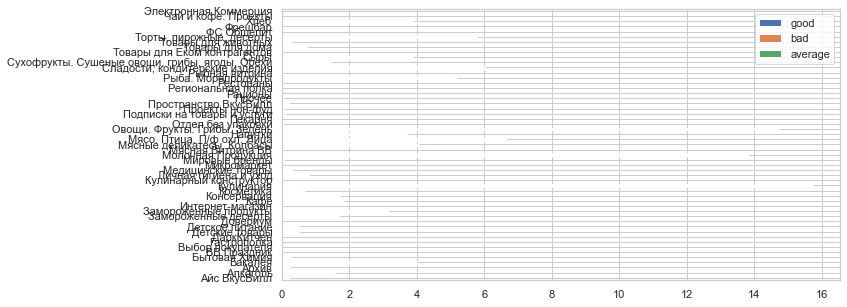

In [ ]:
all_cat_perfomance = df_category_diff.plot(kind="barh",figsize=(10,40))
fig = grap1.get_figure()
fig.tight_layout()
fig.savefig('all_cat_perfomance.jpeg')